# LSDB Commisioning Project 4: Find RRLyrae variables in ComCam data

## Installation

In [1]:
%pip install lsdb astropy light_curve 'dask<2025'

Note: you may need to restart the kernel to use updated packages.


In [2]:
import lsdb
lsdb.__version__

'0.4.4'

In [3]:
# Relevant Directories
#ls /sdf/scratch/users/n/ncaplar/HATS

comcam_obj = "/sdf/data/rubin/shared/lsdb_commissioning/Object_50"
comcam_src = "/sdf/data/rubin/shared/lsdb_commissioning/forcedSource_50"
comcam_diasrc = "/sdf/data/rubin/shared/lsdb_commissioning/diaSource_50"
comcam_srcmjd = "/sdf/data/rubin/shared/lsdb_commissioning/forcedSource_50_with_mjd"

## Loading ComCam Data into LSDB

In [4]:
from dask.distributed import Client

# Start with a small client
client = Client(n_workers=24, memory_limit="8GB", threads_per_worker=1)
client

/sdf/home/k/kostya/rubin-user/linccf/.venv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36097 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36097/status,
Dashboard: http://127.0.0.1:36097/status,Workers: 24
Total threads: 24,Total memory: 178.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39375,Workers: 24
Dashboard: http://127.0.0.1:36097/status,Total threads: 24
Started: Just now,Total memory: 178.81 GiB
Comm: tcp://127.0.0.1:34065,Total threads: 1
Dashboard: http://127.0.0.1:34665/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:46137,


## Loading & Nesting Forced Sources

In [8]:
# Load the Forced Source + MJD Table
import nested_dask as nd

src_mjd_ddf = nd.read_parquet("/sdf/data/rubin/shared/lsdb_commissioning/forcedSource_50_with_mjd", calculate_divisions=True)
src_nested = nd.NestedFrame.from_flat(src_mjd_ddf, base_columns=["coord_ra", "coord_dec"],
                                      nested_columns=["band", "psfFlux", "psfFluxErr", "midpointMjdTai"],
                                      name="lc")
src_nested


,coord_ra,coord_dec,lc
npartitions=310,,,
199279885464633345,double[pyarrow],double[pyarrow],"nested<band: [large_string], psfFlux: [double], psfFluxErr: [double], midpointMjdTai: [double]>"
199548166301815239,...,...,...
...,...,...,...
4708143974508930760,...,...,...
4708236333485657710,...,...,...


In [9]:
# Grab columns from the Object Catalog
from lsdb import read_hats
obj_ddf = read_hats(comcam_obj, columns=["objectId", "g_psfFlux", "r_psfFlux"])._ddf.set_index("objectId")

# LSDB joins with non-catalogs don't really work, so cheating by using native Dask/Nested-Dask
src_nested = src_nested.join(obj_ddf).dropna(subset=["g_psfFlux", "r_psfFlux"])
src_nested

,coord_ra,coord_dec,lc,g_psfFlux,r_psfFlux
npartitions=393,,,,,
199279885464633345,double[pyarrow],double[pyarrow],"nested<band: [large_string], psfFlux: [double], psfFluxErr: [double], midpointMjdTai: [double]>",double[pyarrow],double[pyarrow]
199389836627411188,...,...,...,...,...
...,...,...,...,...,...
4708143974508930760,...,...,...,...,...
4708236333485657710,...,...,...,...,...


In [10]:
# Pre-Processing

# Use just r-band data
# src_nested = src_nested.query("lc.band == 'r'").dropna(subset="lc")

# S/N >= 3
src_nested = src_nested.query("lc.psfFlux / lc.psfFluxErr >= 5").dropna(subset="lc")

MIN_NOBS = 100
MIN_NOBS_BAND = 50

# Count the length of the lightcurves, and add a length filter
from nested_dask.utils import count_nested
src_nested = count_nested(src_nested, "lc", join=True).query(f"n_lc >= {MIN_NOBS}")

In [12]:
len(src_nested) # number of lightcurves after the above cuts

149347

## Running Lomb-Scargle
Use Lightcurve package

In [13]:
import light_curve as licu
import numpy as np
from astropy.timeseries import LombScargleMultiband

periodogram_extractor = licu.Periodogram(
    peaks=10,
    nyquist='average',
    resolution=100,
    max_freq_factor=10,
    fast=False,
)
reduced_chi2_extractor = licu.ReducedChi2()

MAX_PERIOD = 50  # days
MIN_PERIOD = 1 / 24
BANDS = 'ugrizy'


def extract_period_multiband_licu(band, t, flux, fluxerr, **kwargs):
    # We offset date, so we still would have <1 second precision

    _, sort_index = np.unique(t, return_index=True)
    band, t, flux, fluxerr = band[sort_index], t[sort_index], flux[sort_index], fluxerr[sort_index]
    mag = -2.5 * np.log10(flux)
    magerr = 2.5 / np.log(10) * fluxerr / flux

    band_freqs = []
    band_periodograms = []
    band_weights = []
    periods = []
    s2n = []
    for b in BANDS:
        band_idx = band == b

        # At least few points in the band
        if np.count_nonzero(band_idx) < MIN_NOBS_BAND:
            continue
        
        band_t = t[band_idx]
        band_mag = mag[band_idx]
        band_magerr = magerr[band_idx]

        freq, periodogram = periodogram_extractor.freq_power(band_t, band_mag)
        freq_idx = (freq > 2*np.pi / MAX_PERIOD) & (freq < 2*np.pi / MIN_PERIOD)
        if not np.any(freq_idx):
            continue
        band_freqs.append(freq[freq_idx])
        band_periodograms.append(periodogram[freq_idx])

        reduced_chi2 = reduced_chi2_extractor(band_t, band_mag, band_magerr, **kwargs)[0]
        chi2 = reduced_chi2 * (len(band_t) - 1)
        band_weights.append(chi2)

        idx_band_period = np.argmax(band_periodograms[-1])
        periods.append(2*np.pi / band_freqs[-1][idx_band_period])
        s2n.append(band_periodograms[-1][idx_band_period] / np.std(band_periodograms[-1], ddof=1))

    if len(band_periodograms) == 0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    freq = np.unique(np.concatenate(band_freqs))
    periodograms = [np.interp(freq, f, p, left=np.mean(p), right=np.mean(p)) for f, p in zip(band_freqs, band_periodograms)]
    multiband_periodogram = np.average(periodograms, weights=band_weights, axis=0)

    idx_multiband_period = np.argmax(multiband_periodogram)
    multiband_s2n = multiband_periodogram[idx_multiband_period] / np.std(multiband_periodogram, ddof=1)
    multiband_period = 2*np.pi / freq[idx_multiband_period]

    periods.append(multiband_period)
    s2n.append(multiband_s2n)

    best_period = periods[np.argmax(s2n)]
    best_s2n = s2n[np.argmax(s2n)]

    # Return the features as a dictionary
    return {"period_0": best_period, "period_s_to_n_0": best_s2n}


def extract_period_singleband_licu(band, t, flux, fluxerr, **kwargs):
    del fluxerr  # unused

    _, sort_index = np.unique(t, return_index=True)
    band, t, flux = band[sort_index], t[sort_index], flux[sort_index]
    
    periods = []
    s2n = []
    for b in BANDS:
        band_index = band == b
        band_t, band_flux = t[band_index], flux[band_index]

        if len(band_t) < MIN_NOBS_BAND:
            continue

        band_mag = -2.5 * np.log10(band_flux)

        features = periodogram_extractor(band_t, band_mag, **kwargs)
        periods.extend(features[::2])
        s2n.extend(features[1::2])
    periods, s2n = np.asarray(periods), np.asarray(s2n)
    
    if len(periods) == 0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}
    
    idx_periods = (periods > MIN_PERIOD) & (periods < MAX_PERIOD)
    if not np.any(idx_periods):
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}
    periods_inrange, s2n_inrange = periods[idx_periods], s2n[idx_periods]
    
    idx_best_period = np.argmax(s2n_inrange)
    best_period = periods_inrange[idx_best_period]
    best_s2n = s2n_inrange[idx_best_period]

    return {"period_0": best_period, "period_s_to_n_0": best_s2n}

def extract_period_rband_licu(band, t, flux, fluxerr, **kwargs):
    del fluxerr  # unused

    _, sort_index = np.unique(t, return_index=True)
    band, t, flux = band[sort_index], t[sort_index], flux[sort_index]

    r_band = band == 'r'
    t, flux = t[r_band], flux[r_band]
    
    if len(t) < MIN_NOBS_BAND:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    mag = -2.5 * np.log10(flux)

    features = periodogram_extractor(t, mag, **kwargs)
    periods, s2n = features[::2], features[1::2]
    
    idx_periods = (periods > MIN_PERIOD) & (periods < MAX_PERIOD)
    if not np.any(idx_periods):
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    best_period = periods[idx_periods][0]
    best_s2n = s2n[idx_periods][0]

    return {"period_0": best_period, "period_s_to_n_0": best_s2n}


def extract_period_multiband_astropy(band, t, flux, fluxerr, **kwargs):
    del kwargs  # unused

    mag = -2.5 * np.log10(flux)
    magerr = 2.5 / np.log(10) * fluxerr / flux
    freq, power = LombScargleMultiband(t, mag, band, magerr).autopower()
    
    freq_idx = (freq > 1 / MAX_PERIOD) & (freq < 1 / MIN_PERIOD)
    freq, power = freq[freq_idx], power[freq_idx]
    
    if len(freq) == 0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    idx_period = np.argmax(power)
    period = 1 / freq[idx_period]
    s2n = power[idx_period] / np.std(power, ddof=1)
    return {"period_0": period, "period_s_to_n_0": s2n}


features = src_nested.reduce(
    extract_period_rband_licu,
    "lc.band",
    "lc.midpointMjdTai",
    "lc.psfFlux",
    "lc.psfFluxErr",
    meta={"period_0": float, "period_s_to_n_0": float},
)

src_nested_w_features = src_nested.join(features)

In [14]:
# src_nested_w_features.head(5, npartitions=-1)

## Periodic Candidate Selection
* Have periods of ~0.3–0.6 days

In [15]:
%%time
# Look for periods around half a day, select for high periodogram S/N
src_nested_periodic_cand = src_nested_w_features.query(
    "period_s_to_n_0 > 10"
)

CPU times: user 8.4 ms, sys: 1.02 ms, total: 9.42 ms
Wall time: 7.9 ms


In [16]:
# len(src_nested_periodic_cand)

## Plotting a few Phase-Folded Candidates

In [17]:
# cand_subset = src_nested_periodic_cand.head(1000, npartitions=-1)
cand_subset = src_nested_periodic_cand.compute()
cand_subset = cand_subset.sort_values(by="period_s_to_n_0", ascending=False)
cand_subset

,coord_ra,coord_dec,lc,g_psfFlux,r_psfFlux,n_lc,period_0,period_s_to_n_0
objectId,,,,,,,,
2132995383280798076,53.343562,-28.420403,band psfFlux psfFluxErr midpoint...,34169.817202,118038.325127,446,2.027787,17.197959
2132995383280813316,53.343562,-28.420403,band psfFlux psfFluxErr midpoint...,34167.565936,118034.443718,446,2.027787,17.197957
2226836501688221887,53.084536,-28.026264,band psfFlux psfFluxErr midpointM...,1197792.363542,1686420.260227,745,2.023928,14.652019
2226836501688231435,53.084536,-28.026264,band psfFlux psfFluxErr midpointM...,1197790.205349,1686418.278822,745,2.023928,14.652019
2226796919269625234,53.084536,-28.026264,band psfFlux psfFluxErr midpointM...,1197855.29708,1687148.388692,762,2.023910,14.006760
2226792521223114015,53.084536,-28.026264,band psfFlux psfFluxErr midpointM...,1197996.765751,1686224.787386,759,2.024017,13.951580
2226840899734742739,53.084536,-28.026264,band psfFlux psfFluxErr midpointM...,1198208.9493,1687257.285237,744,2.024126,13.604613
2226840899734732934,53.084536,-28.026264,band psfFlux psfFluxErr midpointM...,1198215.725728,1687264.801958,744,2.024126,13.604612
2226744142711502386,53.361869,-28.289535,band psfFlux psfFluxErr midpointMj...,8815.898359,25965.057255,632,0.503322,13.095781


2132995383280798076
2132995383280813316
2226836501688221887
2226836501688231435
2226796919269625234
2226792521223114015
2226840899734742739
2226840899734732934
2226744142711502386
2226744142711490411
2226792521223123443
2226792521223112564
2226796919269623439
2133039363745909395
2133039363745922464
2226788123176620442
2226832103641710920
2226788123176604147
2132999781327327267
2132999781327310556


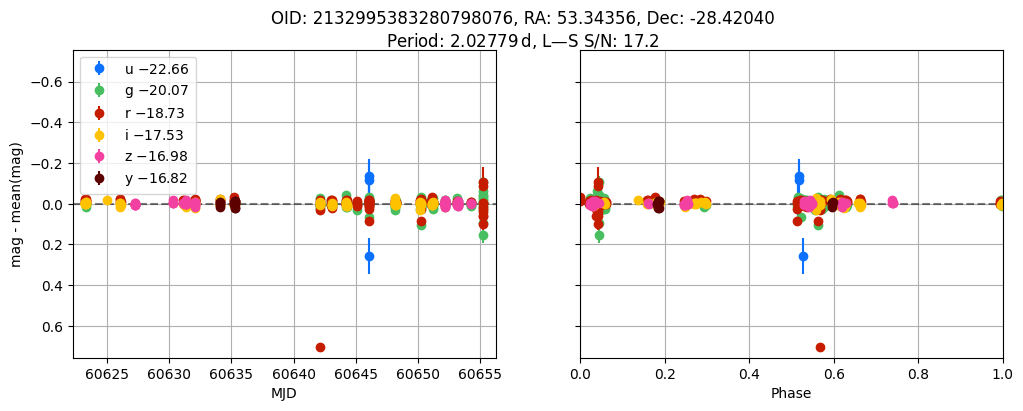

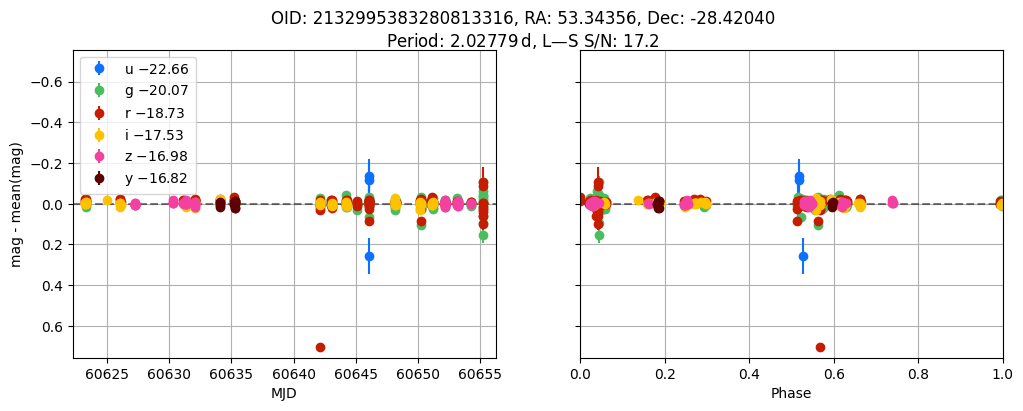

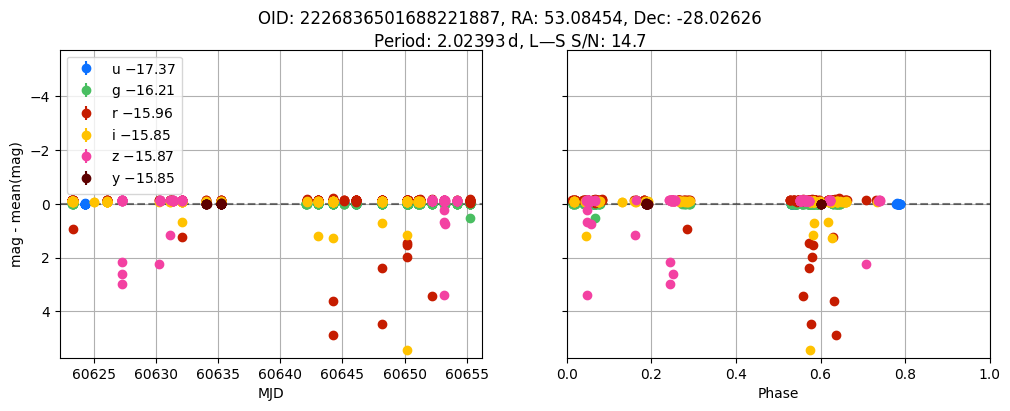

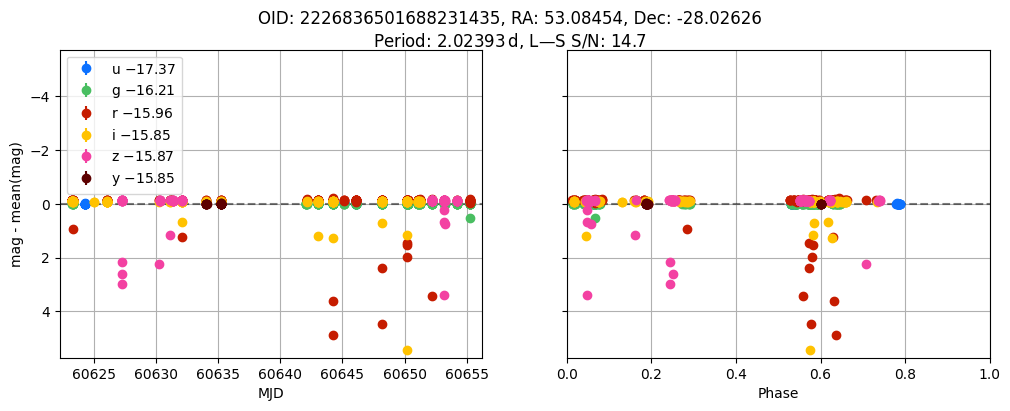

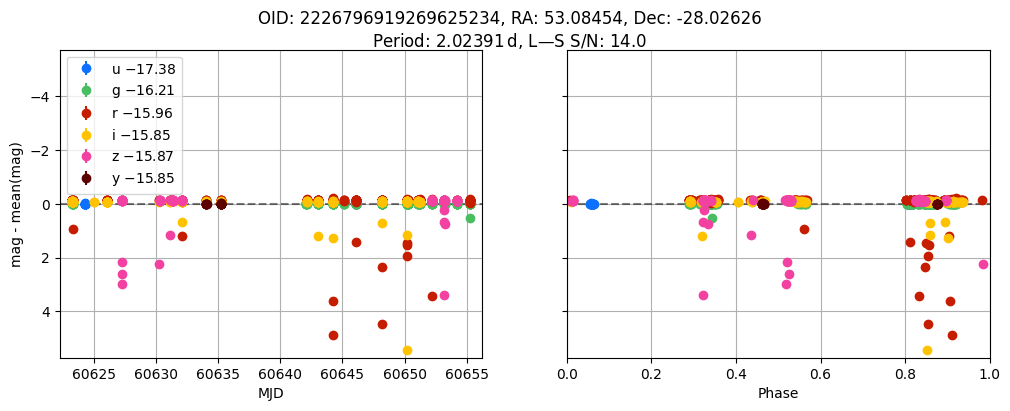

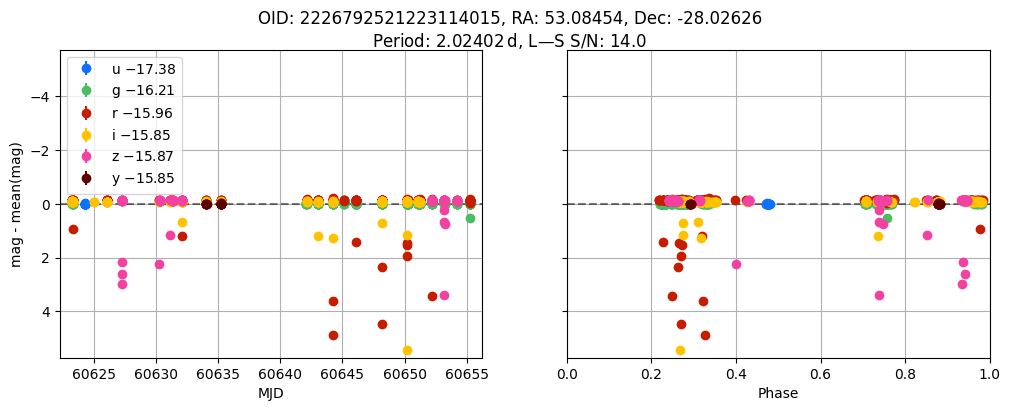

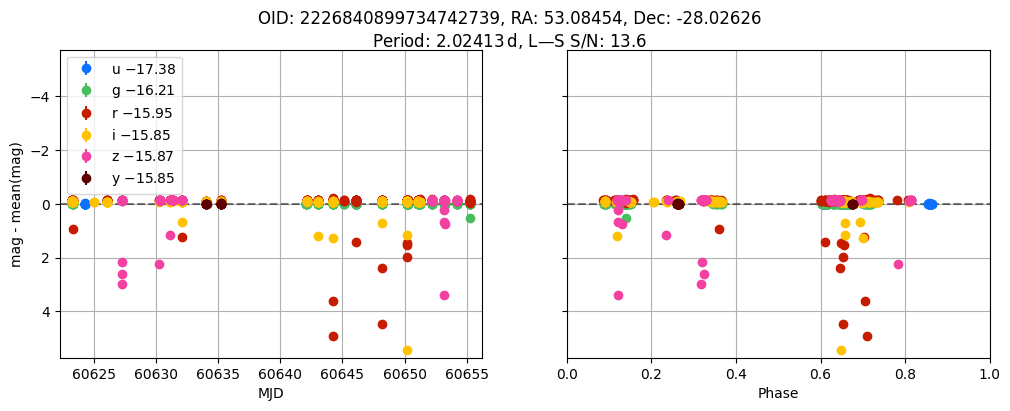

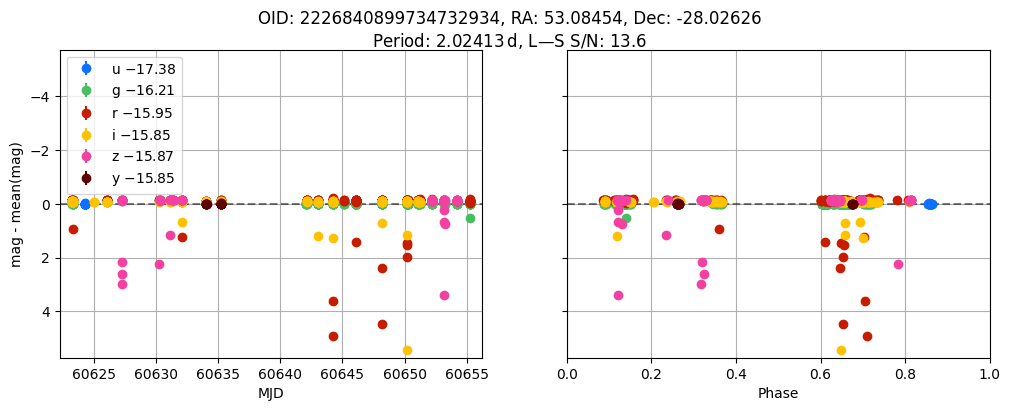

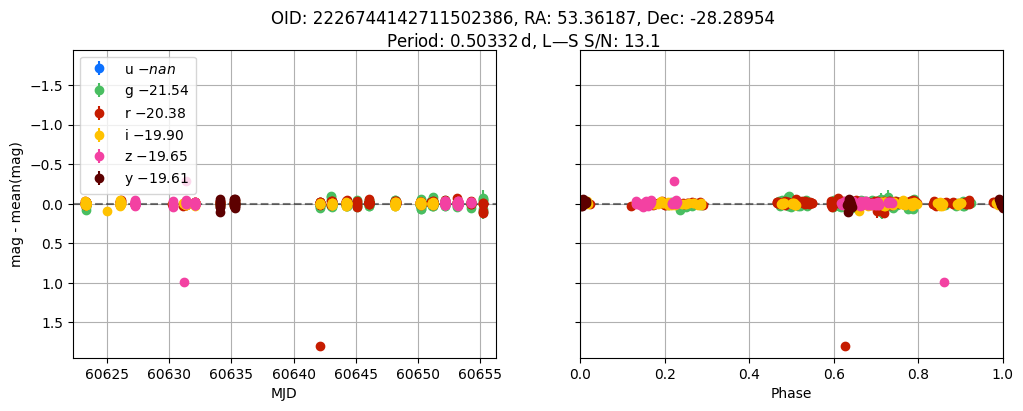

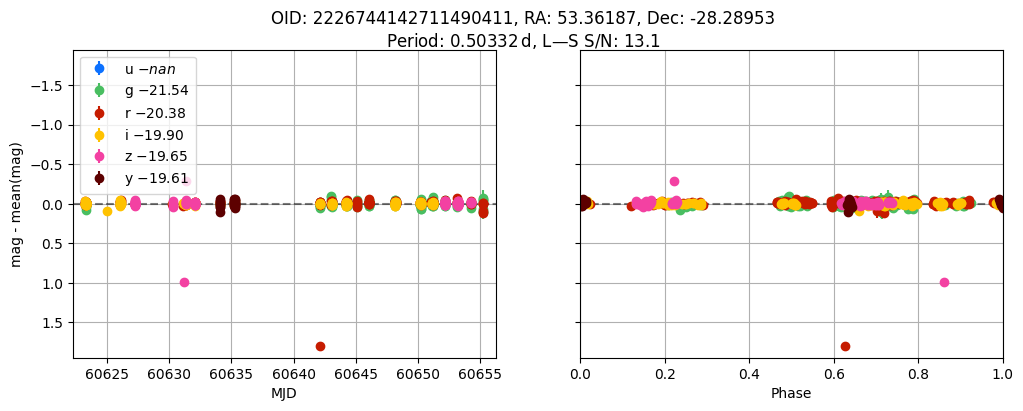

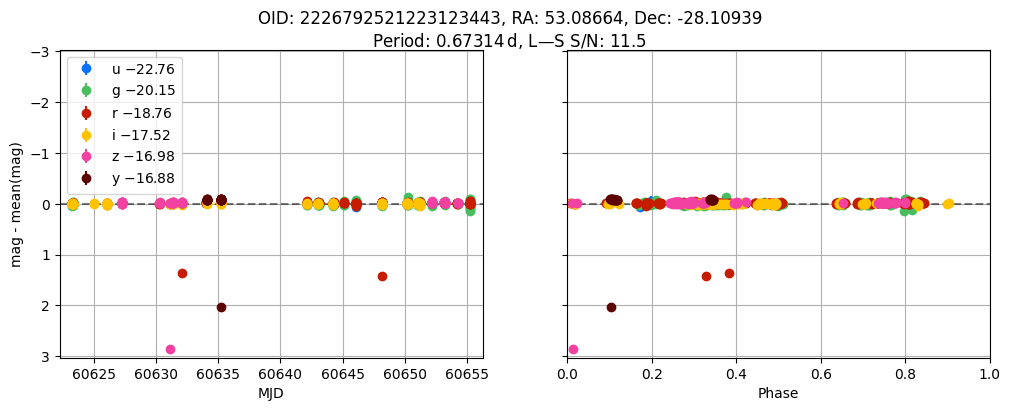

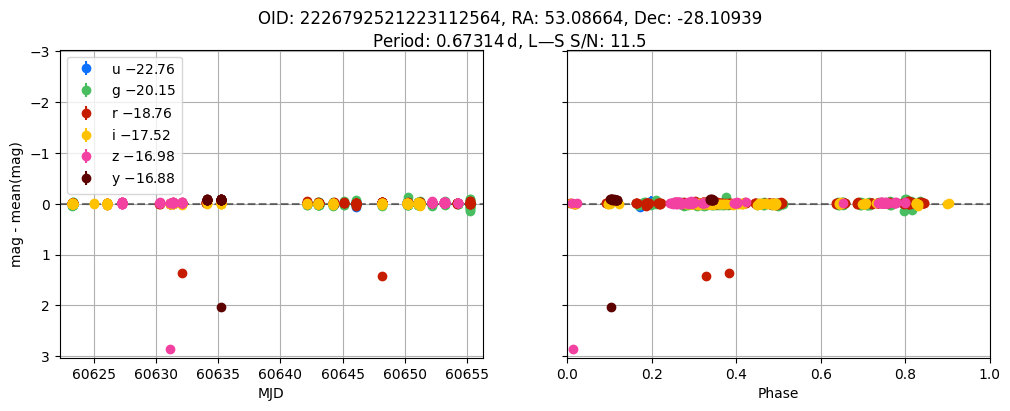

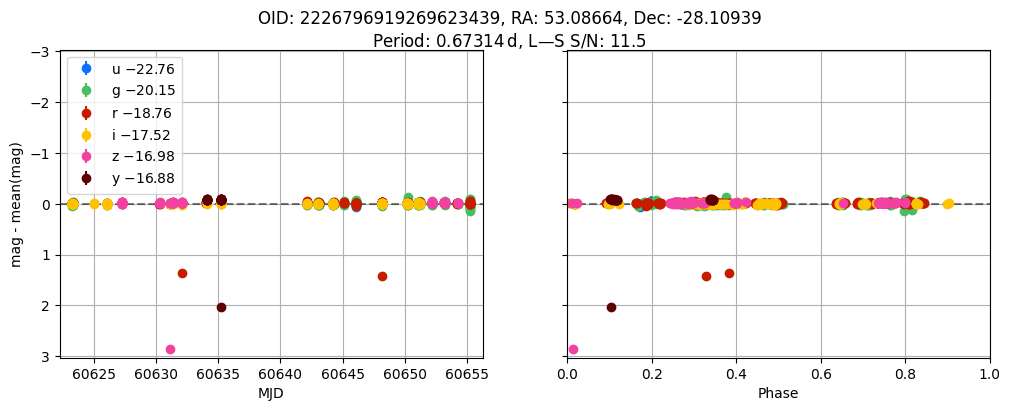

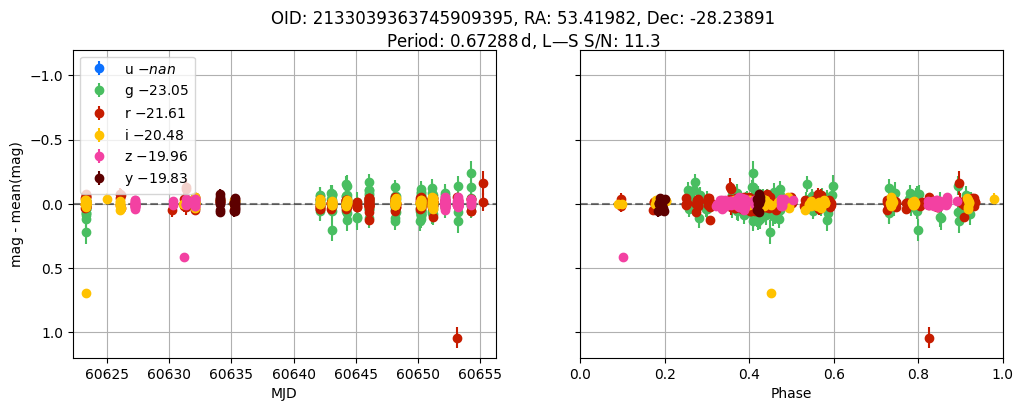

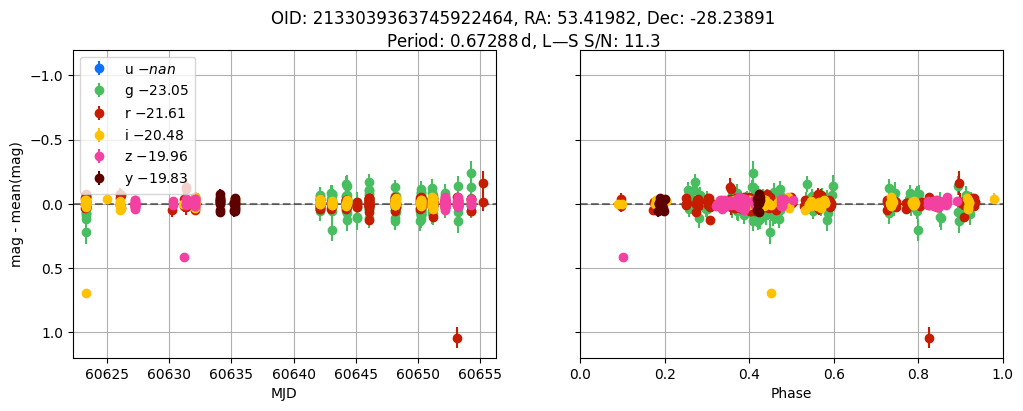

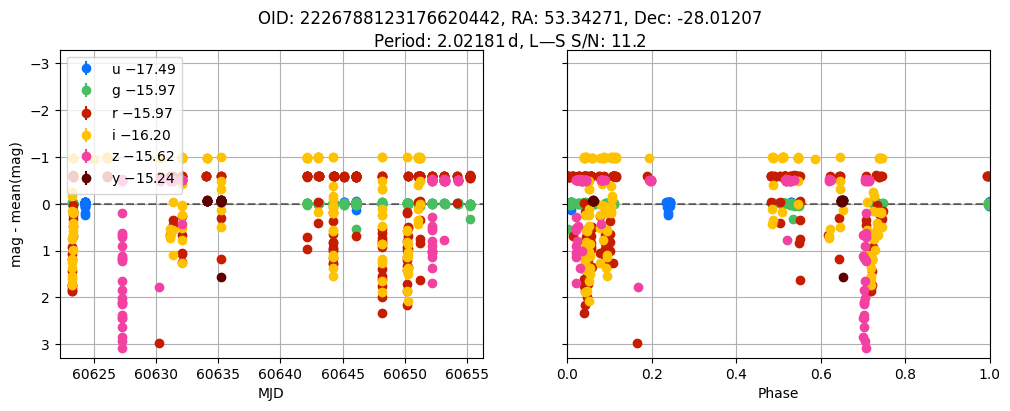

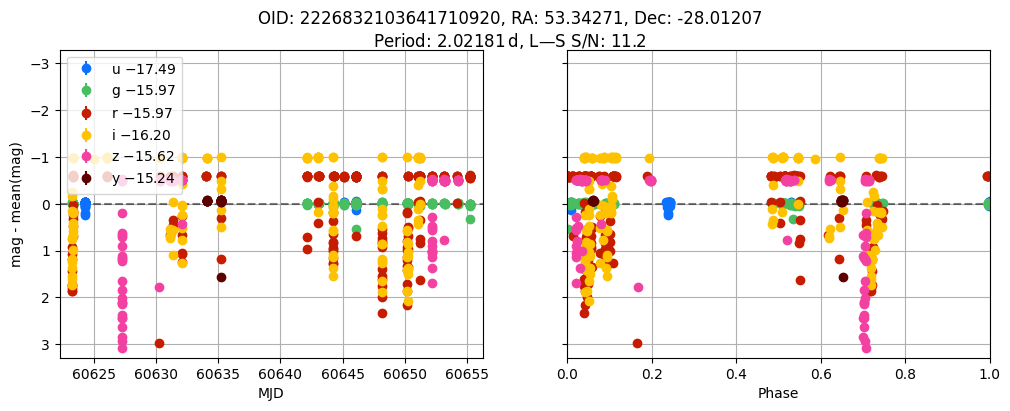

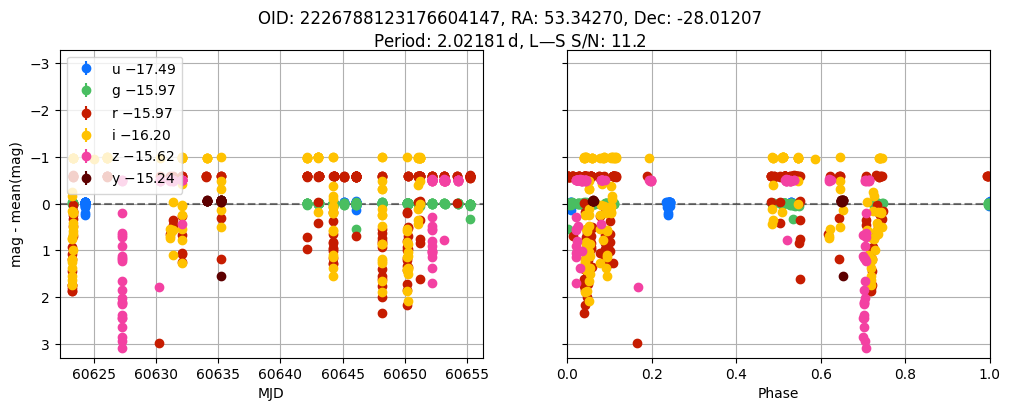

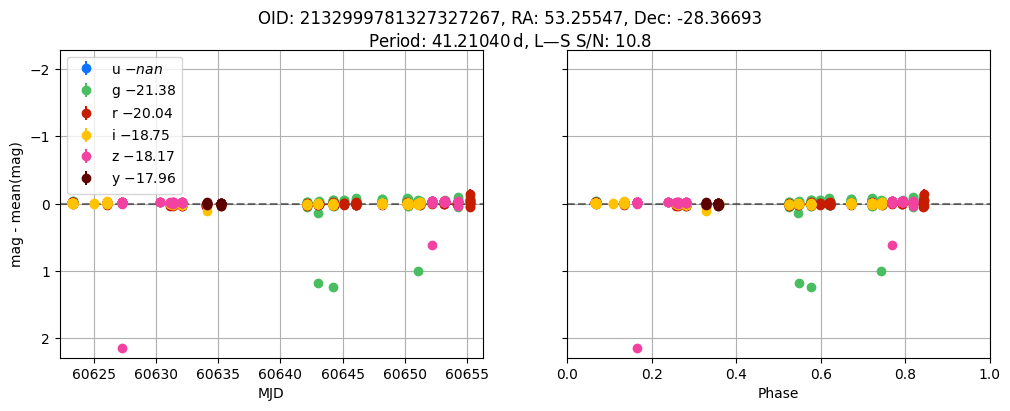

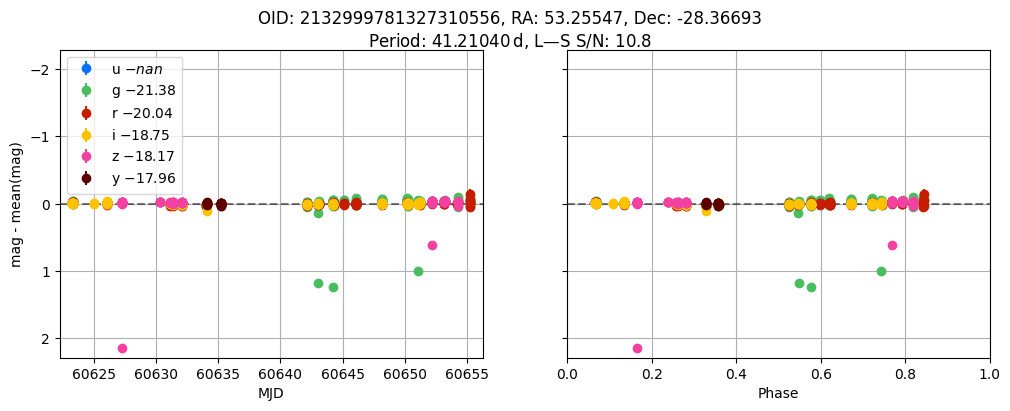

In [18]:
import matplotlib.pyplot as plt

COLORS = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00',
          'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

FOLDED = True

for healpix29, cand in cand_subset.iloc[:20].iterrows():
    phase = cand.lc["midpointMjdTai"] % cand["period_0"] / cand["period_0"]
    mag = -2.5 * np.log10(cand.lc["psfFlux"]) + 31.4
    magerr = 2.5 / np.log(10) * cand.lc["psfFluxErr"] / cand.lc["psfFlux"]
    fig, (ax_mjd, ax_phase) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    for b in BANDS:
        idx = (cand.lc["band"] == b) & (magerr < 0.1)
        mean_band_mag = np.mean(mag[idx])
        errorbar_kwargs = dict(
            y=mag[idx] - mean_band_mag,
            yerr=magerr[idx],
            fmt="o",
            color=COLORS[b],
            label=f'{b} $- {mean_band_mag:.2f}$',
        )
        ax_mjd.errorbar(cand.lc["midpointMjdTai"][idx], **errorbar_kwargs)
        ax_phase.errorbar(phase[idx], **errorbar_kwargs)
    fig.suptitle(
        f"OID: {cand.name}, RA: {cand['coord_ra']:.5f}, Dec: {cand['coord_dec']:.5f}"
        f"\nPeriod: {cand['period_0']:.5f}$\,$d, L—S S/N: {cand['period_s_to_n_0']:.1f}"
    )
    ax_mjd.set_ylabel("mag - mean(mag)")

    ax_mjd.set_xlabel("MJD")
    ax_mjd.set_xlim(np.min(cand.lc["midpointMjdTai"])-1, np.max(cand.lc["midpointMjdTai"])+1)
    ax_phase.set_xlabel("Phase")
    ax_phase.set_xlim(0, 1)
    
    max_abs_ylim = max(np.abs(plt.ylim()))
    plt.ylim(-max_abs_ylim, max_abs_ylim)    
    plt.gca().invert_yaxis()
    ax_mjd.plot(ax_mjd.get_xlim(), [0, 0], color='k', linestyle='--', alpha=0.5)
    ax_phase.plot(ax_phase.get_xlim(), [0, 0], color='k', linestyle='--', alpha=0.5)
    ax_mjd.legend(loc='upper left')
    ax_mjd.grid()
    ax_phase.grid()
    
    print(cand.name)

### Potentially Interesting Candidates
2226748540758018644, 2226840899734749849, 2226796919269630775